# Setup

In [19]:
using Pkg
Pkg.activate("SCC", shared=true)


import QuantumToolbox as qt
using Logging
import CairoMakie as cm
cm.activate!(type = "png")
using Makie.Colors
using Makie.GeometryBasics

using DifferentialEquations
using MiniLoggers
using ProgressMeter
using LoggingExtras
using Revise
using Dates
using YAXArrays
using DimensionalData

import Optim as OP

using LinearAlgebra
import LsqFit as LF

import Peaks
using Zygote

using JSON3

  Activating project at `~/.julia/environments/SCC`


In [2]:
import SuperconductingCavities as SC

[ Info: new driver key :netcdf, updating backendlist.


## Logging Setup

In [4]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Base.CoreLogging.default_metafmt, true, 0, Dict{Any, Int64}())

## Some Universal Formatting Stuff

In [214]:
greens = [colorant"#1B5E20", colorant"#388E3C", colorant"#66BB6A", colorant"#C8E6C9"] # Green
oranges = [colorant"#FF6F00", colorant"#FFA000", colorant"#FFCA28", colorant"#FFECB3"] # Orange 
#colors2 = [colorant"#FF6F00", colorant"#FFA000", colorant"#FFEB3B", colorant"#FFE082"] # Orange
blues = [colorant"#1A237E", colorant"#1976D2", colorant"#03A9F4", colorant"#90CAF9"] # Blue
reds = [colorant"#880E4F", colorant"#D81B60", colorant"#F06292", colorant"#F8BBD0"] # Red
purples = [colorant"#4A148C", colorant"#7B1FA2", colorant"#AB47BC", colorant"#E1BEE7"] # Purple
colors = hcat(colors0, colors1, colors2, colors3, colors4) #permutedims(hcat(colors1, colors2, colors3, colors4), (2,1));
colors = hcat(greens, oranges, blues, reds, purples)

In [196]:
colors[1,1]

In [295]:
c = colors[4,4]
display(c/4)
display(c)

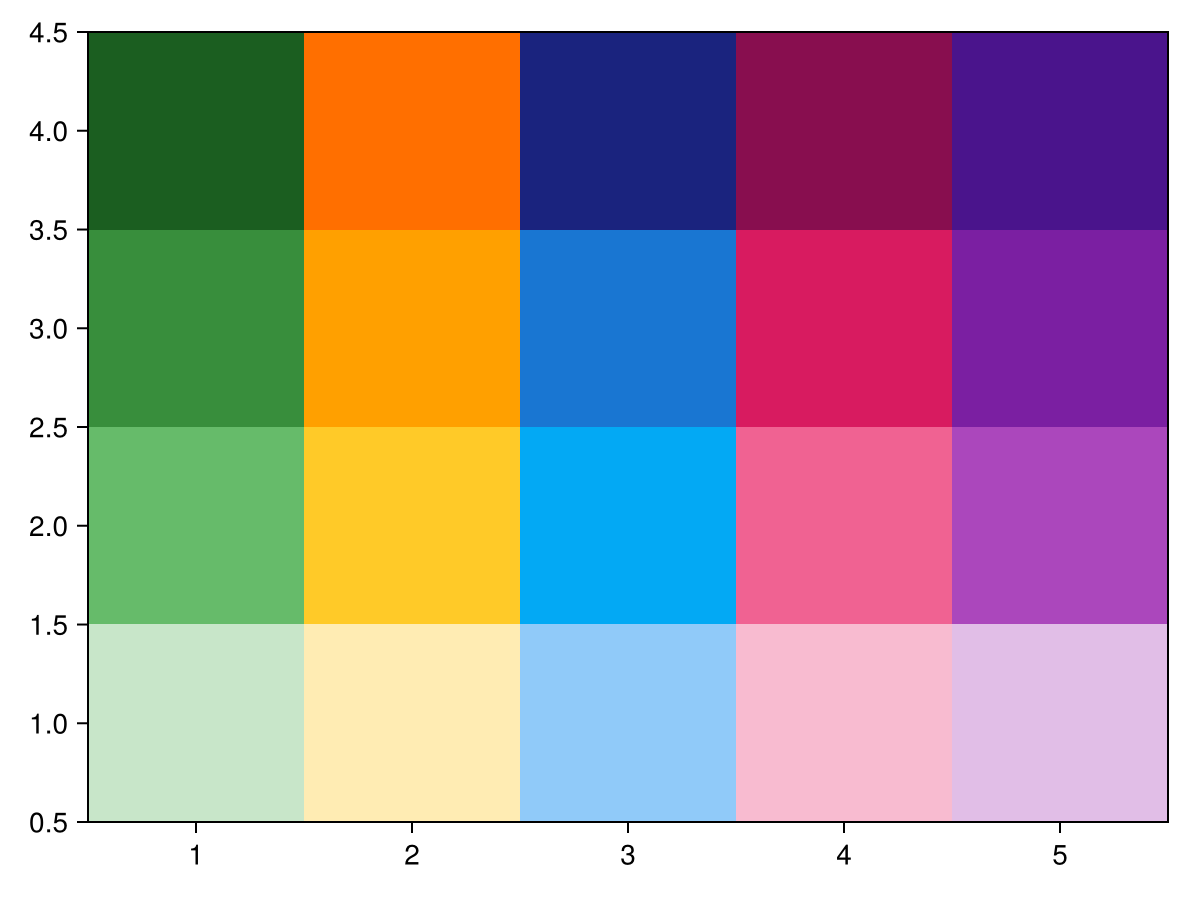

In [197]:
x = 1:4
y = 1:4

z = permutedims(Makie.to_color(colors), (2,1))[:, end:-1:1]

cm.heatmap(z)


# Single Mode State Evolution Plots

## Mode 3

In [5]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

### f0g1 Sidebands

#### Sub Stroboscopic Sampling Plot

##### Getting Data

In [211]:
spns = abs(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+Mode3.Stuff["op_drive_params"]["sb_f0g1"]["shift"])*52
ψi = Mode3.dressed_states[(2,0)]
run_res_sss = SC.Dynamics.RunPulseSequence(Mode3, ψi, ["sb_f0g1"], spns = spns)


The Name for this run is: Operator_Sequence_Thu-Dec-19-24.13.29
It is being saved at: Data/
[2024-12-19 13:29:21] Info: Running operator sb_f0g1
[2024-12-19 13:29:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-12-19 13:29:27] Info: Time Evolution Complete
[2024-12-19 13:29:27] Info: Saving Steps
[2024-12-19 13:29:30] Info: Done with Step_1
[2024-12-19 13:29:30] Info: Done With Running Sequence
[2024-12-19 13:29:30] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.00678965, 0.0135793, 0.0203689, 0.0271586, 0.0339482, …
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [7]:
EVs_sss = SC.Utils.Get_EVs(run_res_sss["states"], SC.Utils.Get_Projection_Ops(Mode3.dressed_states));

##### Plotting

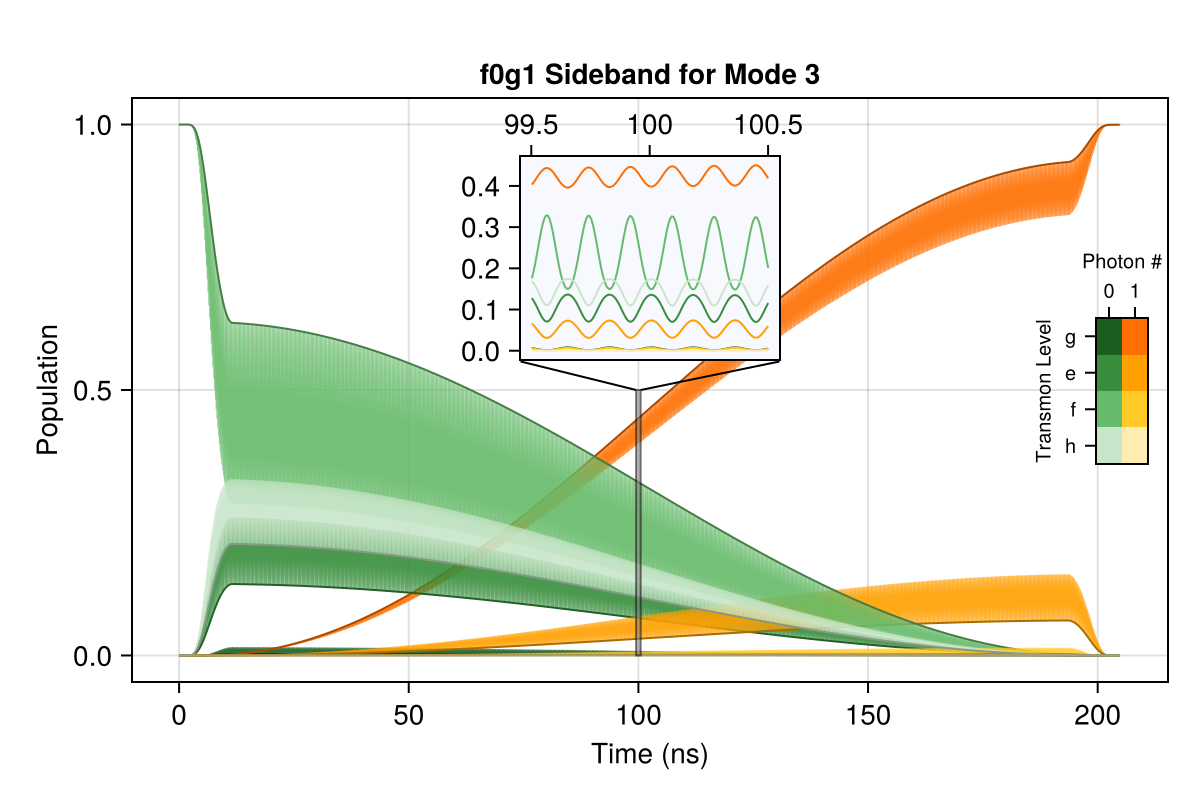

CairoMakie.Screen{IMAGE}


In [300]:
run_res = run_res_sss
EVs = EVs_sss

figsize = (600, 400)
fig = cm.Figure(size = figsize, px_per_unit = 10)

tlevels = [0,1,2,3]
clevels = [0,1]

main_ax = cm.Axis(fig[1,1], title = "f0g1 Sideband for Mode 3", xlabel = "Time (ns)", ylabel = "Population")

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(main_ax, x,y, color = color, linewidth = 0.25, alpha = 0.9)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)

    x = run_res["times"][1:52:end]
    y = real.(EVs[(pair[2],pair[1])])[1:52:end]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(main_ax, x,y, color = color/1.5, linewidth = 1, alpha = 1)
    #cm.lines!(main_ax, [0],[0], color = color, linewidth = 2, alpha = 0.9, label = label, visible = false)
    
end
#cm.Legend(fig[1,2], main_ax, nbanks = 1)
#cm.axislegend(main_ax, position = :rc, nbanks = 2)

w_rel = 0.25
h_rel = 0.35
inset_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.5,
                    valign = 0.85,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([99.5,100,100.5], ["99.5", "100", "100.5"]))
                    
#cm.hidedecorations!(inset_ax)
cm.translate!(inset_ax.scene, 0, 0, 5)
cm.translate!(inset_ax.elements[:background], 0, 0, 5)

start_time = 99.5
stop_time = 100.5

start = findfirst(x -> x > start_time, run_res["times"])
stop = findfirst(x -> x > stop_time, run_res["times"])

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][start:stop]
    y = real.(EVs[(pair[2],pair[1])])[start:stop]
    #cm.scatterlines!(main_ax,x,y, color = (color, 0.1), marker = marker, markersize = 20, linewidth = 0.1)
    cm.lines!(inset_ax, x,y, color = color, linewidth = 1, alpha = 1, label = label)
end

cm.poly!(main_ax, Point2f[(start_time, 0), (stop_time, 0), (stop_time, 0.5), (start_time, 0.5)], color = (:grey, 0.5), strokecolor = (:black, 0.5), strokewidth = 1)

x0 = start_time
y0 = 0.5

xf = w_rel*run_res["times"][end]*1.45
yf = (0.5*h_rel/4+0.51)

cm.lines!(main_ax, [x0, xf], [y0, yf], color = :black, linewidth = 1)

x0 = stop_time
y0 = 0.5
xf = run_res["times"][end] - (w_rel*run_res["times"][end]*1.45)
yf = (0.5*h_rel/4+0.51)

cm.lines!(main_ax, [x0, xf], [y0, yf], color = :black, linewidth = 1)


w_rel = 0.05
h_rel = 0.25
legend_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 0.98,
                    valign = 0.5,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:top),
                    xticks = ([1,2], ["0", "1"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon Level",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[1:2, end:-1:1]
cm.heatmap!(legend_ax, z)




cm.save("figures/f0g1SidebandSubStrobSampling.png", fig, px_per_unit = 10)
display(fig)

### $\ket{0}+\ket{4}$

#### Getting Data

In [229]:
Mode3.Stuff["Drive_Sequences"]["Prep_0_+_4"]

14-element Vector{Any}:
 "q_ge_0"
 "q_half_ef0"
 "sb_f0g1"
 "q_ge_1/2"
 "q_ef_1/2"
 "q_ge_1/2"
 "sb_f1g2"
 "q_ge_1"
 "q_ef_1"
 "q_ge_1"
 "sb_f2g3"
 "q_ge_0"
 "q_ef_0"
 "sb_f3g4"

In [226]:
ψ = Mode3.dressed_states[(0,0)]

prep_0p4_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, Mode3.Stuff["Drive_Sequences"]["Prep_0_+_4"], spns = "Stroboscopic")

The Name for this run is: Operator_Sequence_Thu-Dec-19-24.13.38
It is being saved at: Data/
[2024-12-19 13:38:23] Info: Running operator q_ge_0
[2024-12-19 13:38:24] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-12-19 13:38:26] Info: Time Evolution Complete
[2024-12-19 13:38:26] Info: Saving Steps
[2024-12-19 13:38:27] Info: Done with Step_1
[2024-12-19 13:38:27] Info: Running operator q_half_ef0
[2024-12-19 13:38:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-12-19 13:38:30] Info: Time Evolution Complete
[2024-12-19 13:38:30] Info: Saving Steps
[2024-12-19 13:38:30] Info: Done with Step_2
[2024-12-19 13:38:30] Info: Running operator sb_f0g1
[2024-12-19 13:38:30] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-12-19 13:38:36] Info:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.2172, 0.4344, 0.6516, 0.8688, 1.086, 1.3032, 1.5204, 1.7376…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [227]:
EVs_prep_0p4 = SC.Utils.Get_EVs(prep_0p4_res["states"], SC.Utils.Get_Projection_Ops(Mode3.dressed_states));

#### Plotting

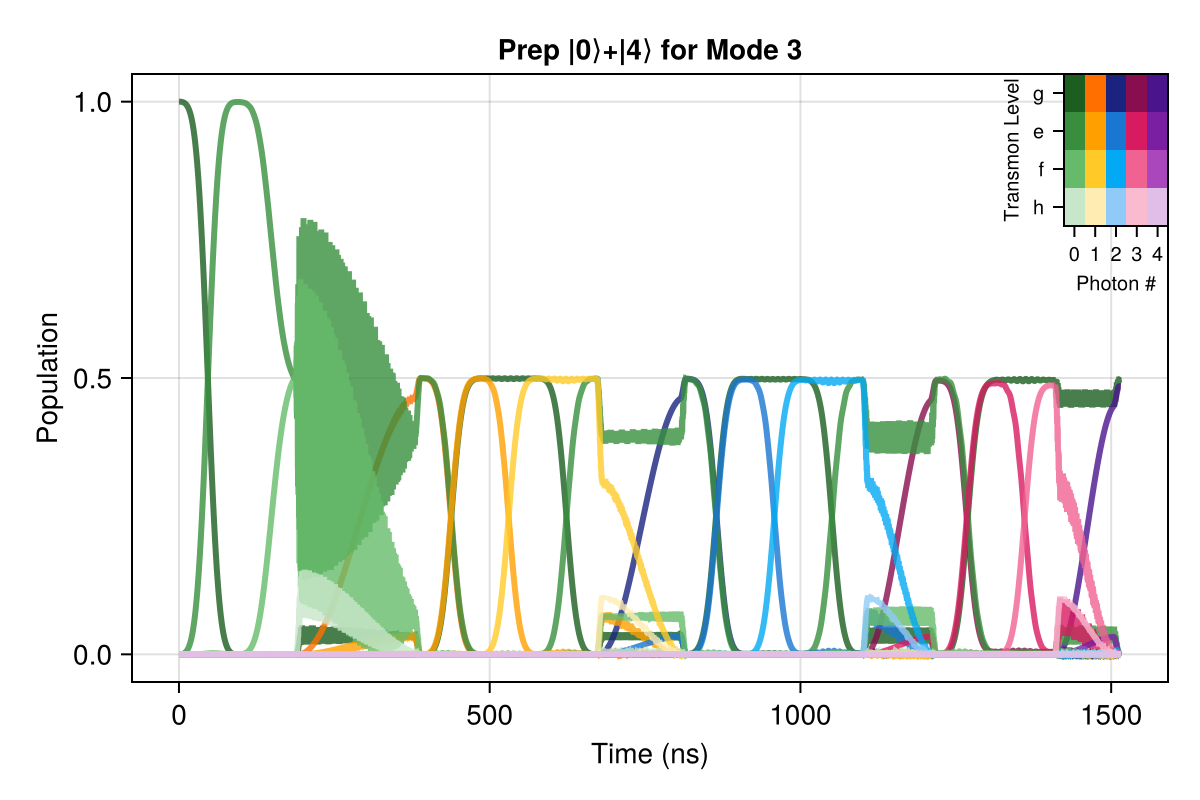

CairoMakie.Screen{IMAGE}


In [255]:
run_res = prep_0p4_res
EVs = EVs_prep_0p4

figsize = (600, 400)
fig = cm.Figure(size = figsize, px_per_unit = 10)

markers = ['∘' , '□', '▿', '▵', '⊲', '⊳'] 
markersizes = [20, 10, 20, 20, 20, 20]

tlevels = [0,1,2,3]
clevels = [0,1,2,3,4]

main_ax = cm.Axis(fig[1,1], title = "Prep |0⟩+|4⟩ for Mode 3", xlabel = "Time (ns)", ylabel = "Population")

for pair in Iterators.product(clevels, tlevels)
    label = "|$(pair[2]), $(pair[1])⟩ "
    color = colors[pair[2]+1,pair[1]+1]

    x = run_res["times"][1:1:end]
    y = real.(EVs[(pair[2],pair[1])])[1:1:end]
    cm.lines!(main_ax, x,y, color = color, linewidth = 3, alpha = 0.8)

    #x = run_res["times"][1:30:end]
    #y = real.(EVs[(pair[2],pair[1])])[1:30:end]
    #cm.lines!(main_ax, x,y, color = color, linewidth = 3, alpha = 0.8)
    #cm.scatterlines!(main_ax, x,y, color = color, linewidth = 0, alpha = 0.8, markersize = markersizes[pair[2]+1], marker = markers[pair[2]+1])
end


w_rel = 0.1
h_rel = 0.25
legend_ax = cm.Axis(fig[1,1], 
                    width = cm.Relative(w_rel),
                    height = cm.Relative(h_rel),
                    halign = 1,
                    valign = 1,
                    backgroundcolor="ghostwhite",
                    xaxisposition = (:bottom),
                    xticks = ([1,2,3,4,5], ["0", "1", "2", "3", "4"]),
                    yticks = ([1,2,3,4], ["h", "f", "e", "g"]),
                    xticklabelsize = 10,
                    yticklabelsize = 10,
                    xlabel = "Photon #",
                    ylabel = "Transmon Level",
                    xlabelsize = 10,
                    ylabelsize = 10)

                    
#cm.hidedecorations!(inset_ax)
cm.translate!(legend_ax.scene, 0, 0, 5)
cm.translate!(legend_ax.elements[:background], 0, 0, 5)
z = permutedims(Makie.to_color(colors), (2,1))[:, end:-1:1]
cm.heatmap!(legend_ax, z)




cm.save("figures/mode3_prep_0_p_4_no_loss.png", fig, px_per_unit = 10)
display(fig)